In [6]:
import math
import json
import requests
import itertools
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from dotenv import load_dotenv
import os
import json
import base64
import itertools
from tqdm.auto import tqdm
import pickle
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns


# ALL CODE

In [7]:
load_dotenv()
client_id = os.getenv("CLIENT_ID")
client_secret = os.getenv("CLIENT_SECRET")

In [8]:
def get_token():
    auth_string = f"{client_id}:{client_secret}"
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")

    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization": f"Basic {auth_base64}",
        "Content-Type": "application/x-www-form-urlencoded", 
        "limit": "50"
        }
    data = {
        "grant_type": "client_credentials"
    }
    result = requests.post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    token = json_result["access_token"]
    return token

def get_auth_header(token):
    return {"Authorization": f"Bearer {token}", "limit": "50"}

def search_for_artist(token, artist):
    url = "https://api.spotify.com/v1/search"
    headers = get_auth_header(token)
    query = f"?q={artist}&type=artist"
    query_url = url + query
    result = requests.get(query_url, headers=headers)
    if result.status_code != 200:
        print('Error: ', result.status_code)
    return result.json()

# Include genres in the query
def get_albums_by_artist(token, artist_id):
    url = f"https://api.spotify.com/v1/artists/{artist_id}/albums"
    headers = get_auth_header(token)
    query = f"?limit=50&"
    query_url = url + query
    result = requests.get(query_url, headers=headers)
    return result.json()

def get_tracks_by_album(token, album_id):
    url = f"https://api.spotify.com/v1/albums/{album_id}/tracks"
    headers = get_auth_header(token)
    query_url = url
    result = requests.get(query_url, headers=headers)
    return result.json()


# Use this for text analysis
def get_songs_by_artist(token, artist_id):
    url = f"https://api.spotify.com/v1/artists/{artist_id}/top-tracks"
    headers = get_auth_header(token)
    query = "?market=US"
    query_url = url + query
    result = requests.get(query_url, headers=headers, params={'genres': True})
    return result.json()


In [9]:
token = get_token()
response = search_for_artist(token, "Post Malone")
id1 = response["artists"]["items"][0]['id']
response["artists"]["items"][0]['genres']

#get_albums_by_artist(token, id1)["items"][0].keys()#["genres"]


Error:  500


KeyError: 'artists'

In [54]:
def set_of_albums_by_artist(ALBUM_json):
    """
    Output: dict of unique album_names and album_ids
    Output example: {
        'Starboy (Deluxe)': '35dut3ICqF3NEDkjxfzJJ1',
        'Live At SoFi Stadium': '1OARrXe5sB0gyy3MhQ8h92', 
    """
    album_names = []
    album_ids = []
    for album in ALBUM_json['items']:
        if album['name'] not in album_names and album['album_type'] == 'album':
            album_names.append(album['name'])
            album_ids.append(album['id'])
    return dict(zip(album_names, album_ids))

# Example
#theWeeknd_albums = get_albums_by_artist(token, id1)
#set_of_albums_by_artist(theWeeknd_albums)

def features_from_album(ALBUM_json):
    """
    Output example: [
        ['Starboy (feat. Daft Punk)', [('Daft Punk', '4tZwfgrHOc3mvqYlEYSvVi')]],
        ['Party Monster', []],
        ...

    ]
    """
    feats_on_album = []
    for i in range(len(ALBUM_json['items'])):
        song_name = ALBUM_json['items'][i]['name']  

        all_features = []
        for features in ALBUM_json['items'][i]['artists']: #[1:]:
            all_features.append( (features['name'], features['id']) )

        feats_on_album.append(all_features)
        #feats_on_album.append([song_name, all_features])

    return feats_on_album

# Example
#starboy_json = get_tracks_by_album(token, WeekndAlbums[0][1])
#features_from_album(starboy_json)

## Make network



1. csv med artist-name
2. Få artist-id  **search_for_artist(token, artist)**
3. Få alle albums **get_albums_by_artist(token, artist)** --> **set_of_albums_by_artist(ALBUM_json)**
4. Få alle features **get_tracks_by_album(token, album_id)** --> **features_from_album(ALBUM_json)**

 1. Er det fair at bruge den liste om Top artists?
 2. ...

In [10]:
dfTopArtist = pd.read_csv('artists_charts.csv')
unique_artists = dfTopArtist['artist'].unique()
unique_artists

array(['Post Malone', 'Juice WRLD', 'Lil Uzi Vert', ...,
       'Das Sound Machine', 'Death Cab for Cutie', 'Purity Ring'],
      dtype=object)

In [11]:
len( unique_artists )

1250

Get raw data with all genres and features for an artist.

In [81]:
dict_genres = {}
dict_features = {}
for artist_name in tqdm(unique_artists[1114:]):
    response = search_for_artist(token, artist_name)
    artist_id = response["artists"]["items"][0]["id"]
    artist_genres = response["artists"]["items"][0]['genres']       # NEW 
    dict_genres[((artist_name,artist_id))] = {'all_genres': artist_genres}    # NEW

    artist_albums = get_albums_by_artist(token, artist_id)
    artist_albums_dict = set_of_albums_by_artist(artist_albums)

    all_features = []
    for album_name, album_id in artist_albums_dict.items():
        album_tracks = get_tracks_by_album(token, album_id)
        album_features = features_from_album(album_tracks)
        all_features.append(album_features)

    # Flatten and remove self
    flattened = list(itertools.chain(*itertools.chain(*all_features)))
    features_no_self = [feat for feat in flattened if feat != (artist_name, artist_id)]

    #dict_features[artist_name] = features_no_self
    # Should maybe have been
    dict_features[(artist_name,artist_id)] = features_no_self

NameError: name 'unique_artists' is not defined

Save the raw collected data:

In [17]:
#with open('dict_featuresALL-modified.pickle', 'wb') as handle:
#    pickle.dump(dict_features, handle)

#with open('dict_genresALL-modified.pickle', 'wb') as handle:
#    pickle.dump(dict_genres1, handle)

Load the data again:

In [18]:
#with open('dict_featuresALL-modified.pickle', 'rb') as handle:
#    dict_features = pickle.load(handle)

#with open('dict_genresALL-modified.pickle', 'rb') as handle:
#    dict_genres = pickle.load(handle)

### Try get one genre

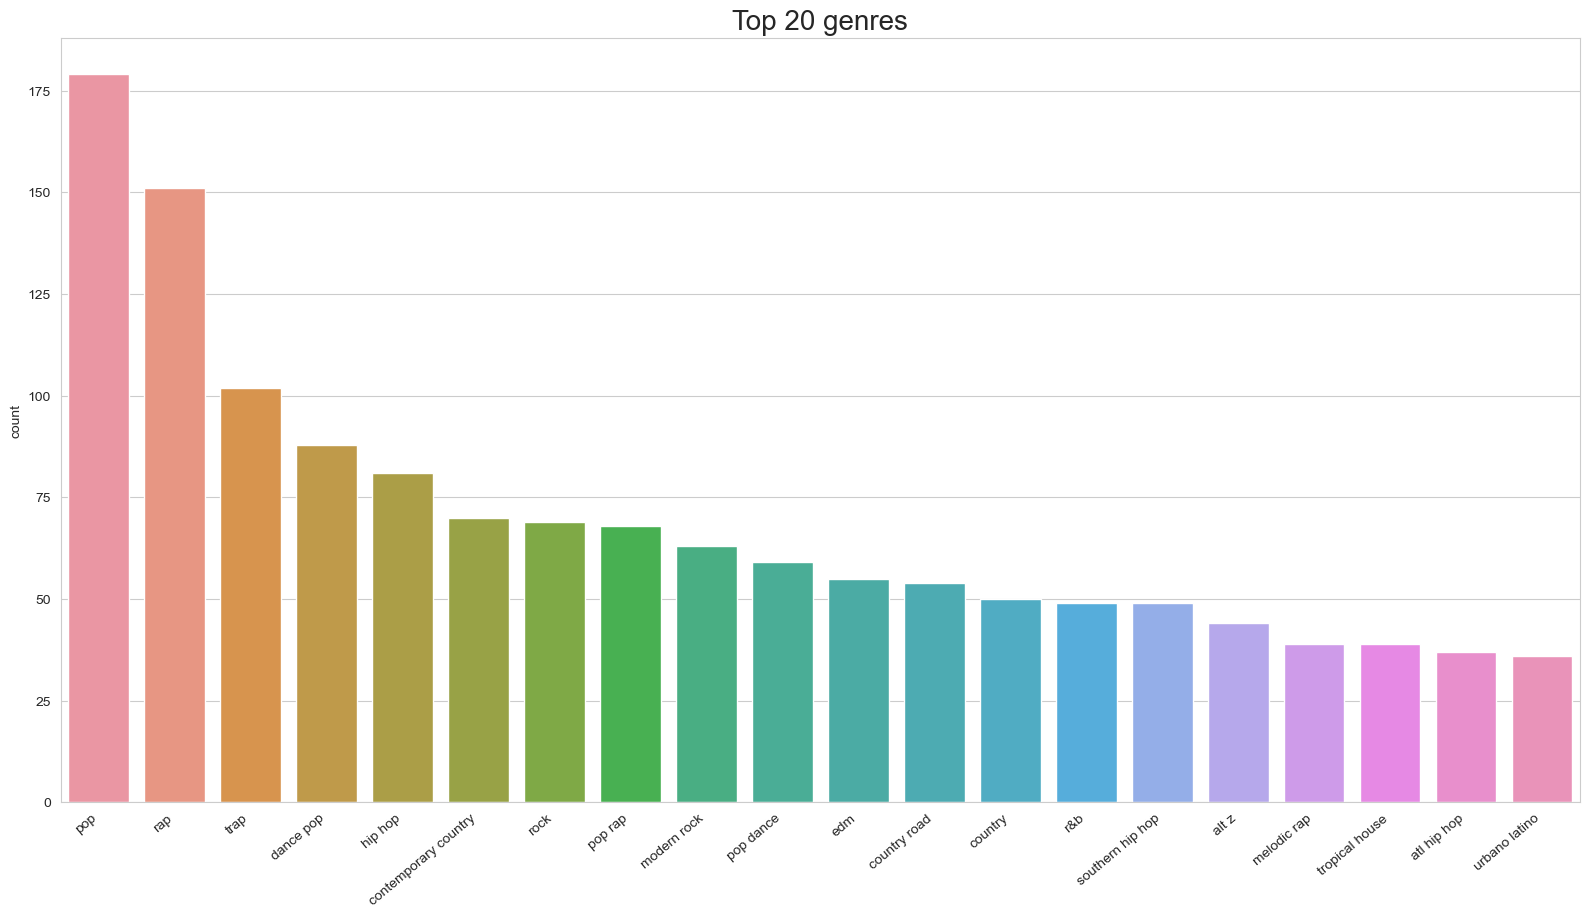

In [130]:
# Make histogram of number af times a genre is used for all artists
def make_hist_of_genres(dict_genres, key_to_use: str, top_n= 20):
    list_of_genres = []
    for dict in dict_genres.values():
        list_of_genres.append(dict[key_to_use])

    if key_to_use == 'all_genres':
        all_genres = list(itertools.chain(*list_of_genres))
        #all_genres = [genre for genre in all_genres if genre != '']
    else:
        all_genres = list_of_genres
    # Make the plot with seaborn
    sns.set_style("whitegrid")
    plt.figure(figsize=(16,9))
    ax = sns.countplot(x=all_genres, order=pd.value_counts(all_genres).iloc[:top_n].index)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.title(f'Top {top_n} genres', fontsize=20)
    plt.show()
    return all_genres
    
all_genres = make_hist_of_genres(dict_genres, 'all_genres')


The idea is getting one genre per artist such that: "dance pop" -> "pop". Thereby a majority vote can be made per artist.

In [163]:
considered_genres = ['ost', 'mellow' , 'cappella', 'stomp' , 'torch', 'sped', 'bass', 'easy', 'show', 'lo-fi', 'mexicana', 'rap', 'trap', 'pop', 'hip', 'r&b', 'rock', 'dance', 'edm', 'new', 'alt', 'electronic', 'country', 'latino', 'indie', 'alternative', 'metal', 'punk', 'jazz', 'blues', 'funk', 'soul', 'orchestra' , 'reggae', 'folk', 'disco', 'classical', 'gospel', 'world', 'christian', 'singer-songwriter', 'acoustic', 'instrumental', 'movie' ,'vocal', 'spoken', 'adult', 'comedy', 'soundtrack', 'musical', 'opera', 'afrofuturism', 'lounge', 'clubbing']
# hip is a one word representation of hip hop
considered_genres = set(all_genres + considered_genres)

def get_top_genre(dict_genres):
    for i, ((artistname, artistid), dict_with_all_genres) in enumerate(dict_genres.items()):
        if dict_with_all_genres['all_genres'] != []:# and artistname == 'Ziv Zaifman':
            genres_single_words = list(itertools.chain(*[genre.split(' ') for genre in dict_with_all_genres['all_genres']]) )

            # Get frequency of each genre
            list_common = Counter(genres_single_words).most_common()
            highest_freq = Counter(genres_single_words).most_common(1)[0][1]
            # Get the genres with the highest frequency (shared first place)
            possible_top_genre = [genre for genre, freq in list_common if freq == highest_freq]
            # Remove genres that are not in the considered genres
            possible_top_genre = [genre for genre in possible_top_genre if genre in considered_genres]

            # Replace some genres with the same meaning
            possible_top_genre = list(map(lambda x: x.replace('hip', 'hip-hop'), possible_top_genre))
            possible_top_genre = list(map(lambda x: x.replace('new', 'new-age'), possible_top_genre))
            possible_top_genre = list(map(lambda x: x.replace('alt', 'alt-z'), possible_top_genre))
            possible_top_genre = list(map(lambda x: x.replace('ost', 'original-soundtrack'), possible_top_genre))
            possible_top_genre = list(map(lambda x: x.replace('show', 'original-soundtrack'), possible_top_genre))
            possible_top_genre = list(map(lambda x: x.replace('easy', 'easy-listening'), possible_top_genre))
            possible_top_genre = list(map(lambda x: x.replace('sped', 'sped-up'), possible_top_genre))
            possible_top_genre = list(map(lambda x: x.replace('cappella', 'a-cappella'), possible_top_genre))


            # We have to choose now. Take the last value, since the order is always 1. hip-hip, 2. rap, 3. trap. 
            if possible_top_genre:
                dict_genres[(artistname, artistid)]['top genre'] = possible_top_genre[-1]
            
            # Check if the artist has a genre (not using split) that is in the considered genres and use that
            else:
                possible_top_genre = [genre for genre in genres_single_words if genre in considered_genres]
                dict_genres[(artistname, artistid)]['top genre'] = possible_top_genre[-1]

        else: # Not genres found
            dict_genres[(artistname, artistid)]['top genre'] = 'No genres'
            
    return dict_genres

dict_genres_updated = get_top_genre(dict_genres)

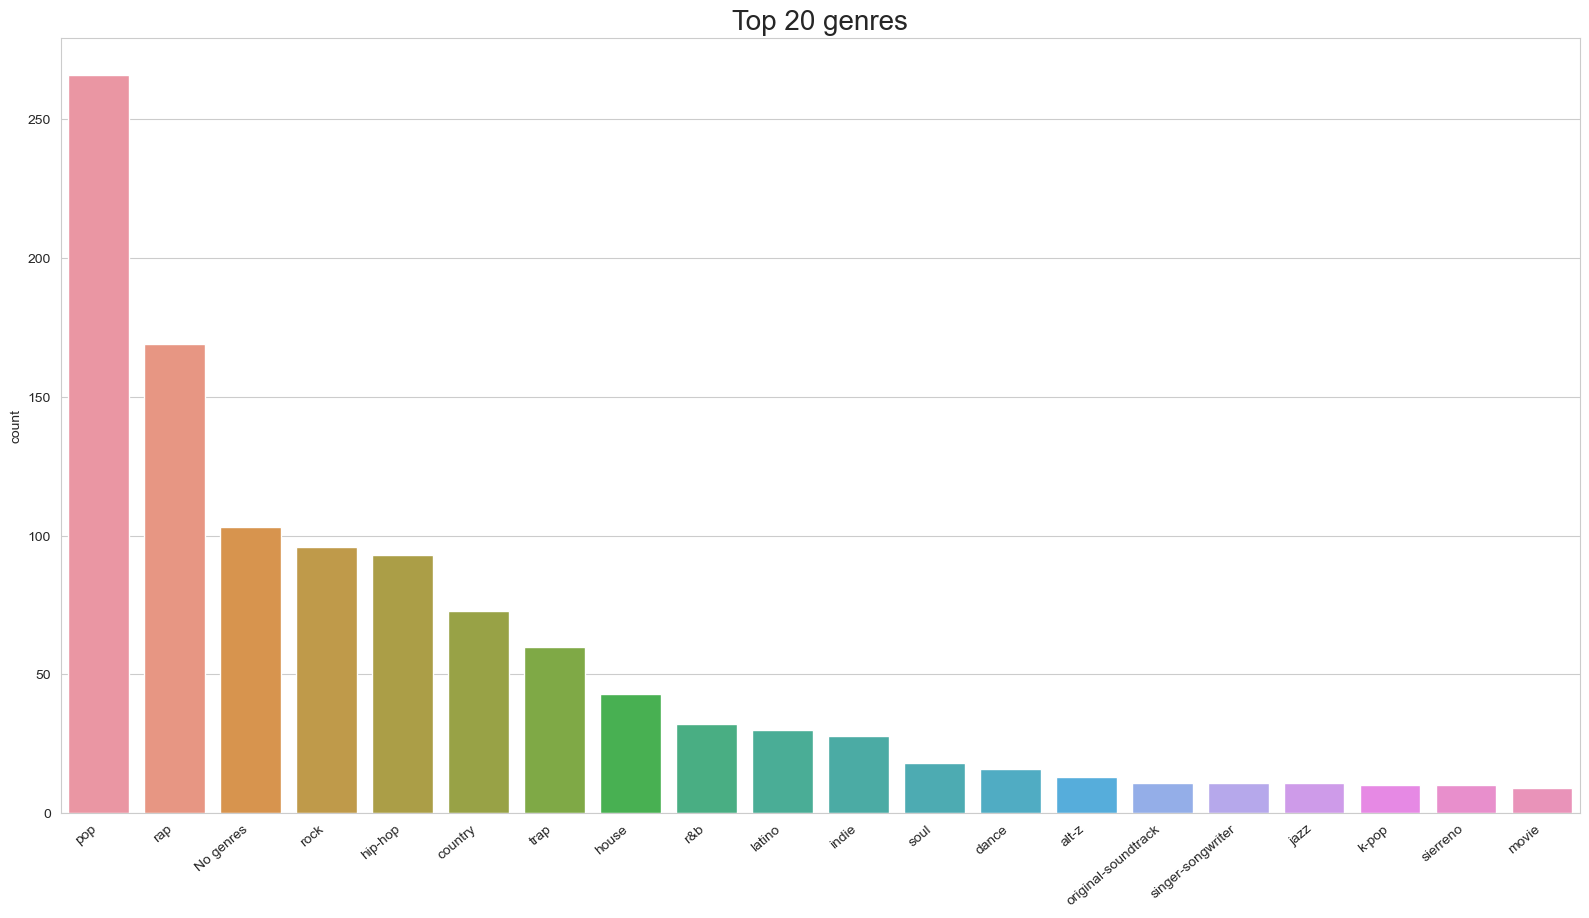

['rap',
 'rap',
 'rap',
 'hip-hop',
 'house',
 'pop',
 'hip-hop',
 'trap',
 'rap',
 'pop',
 'rap',
 'rap',
 'rock',
 'trap',
 'hip-hop',
 'pop',
 'pop',
 'pop',
 'pop',
 'country',
 'pop',
 'house',
 'pop',
 'hip-hop',
 'pop',
 'pop',
 'hip-hop',
 'pop',
 'rap',
 'pop',
 'rap',
 'pop',
 'rap',
 'pop',
 'rap',
 'trap',
 'pop',
 'pop',
 'house',
 'rap',
 'hip-hop',
 'pop',
 'afrofuturism',
 'pop',
 'rap',
 'pop',
 'rap',
 'rap',
 'hip-hop',
 'country',
 'rap',
 'rap',
 'hip-hop',
 'rap',
 'trap',
 'rap',
 'hip-hop',
 'rock',
 'rockabilly',
 'rap',
 'rap',
 'rap',
 'rap',
 'rock',
 'rap',
 'pop',
 'rap',
 'rap',
 'hip-hop',
 'latino',
 'country',
 'rock',
 'rap',
 'pop',
 'pop',
 'rap',
 'rock',
 'pop',
 'pop',
 'pop',
 'hip-hop',
 'pop',
 'rap',
 'hip-hop',
 'trap',
 'rap',
 'No genres',
 'pop',
 'pop',
 'rap',
 'pop',
 'pop',
 'rap',
 'pop',
 'No genres',
 'easy-listening',
 'rock',
 'rap',
 'rap',
 'rock',
 'shaabi',
 'rap',
 'rap',
 'house',
 'rap',
 'pop',
 'rap',
 'pop',
 'rap',
 't

In [167]:
make_hist_of_genres(dict_genres_updated, 'top genre', top_n= 20)


### Actually making network

In [91]:
# Make function to format edges with weight
def format_edges(dict_features, islimitedartists=True):
    """Function to make graph from dict of features. Edges will be features. The weight is features shared between artists."""
    G = nx.Graph()
    print(len(dict_features))
    for artist in dict_features.keys():
        artist_name = artist[0]
        artist_id = artist[1]
        G.add_node(artist_name, label=artist_id)
        res = Counter(dict_features[artist])
        for key in res.keys():
            if key in dict_features.keys() and islimitedartists:
                if G.has_edge(artist_name, key[0]):
                    G.get_edge_data(artist_name, key[0])['weight'] += res[key]
                else:
                    G.add_edge(artist_name, key[0], weight=res[key])
    return G

GGG = format_edges(dict_features)

1250


In [92]:
GGG.number_of_edges()


7621

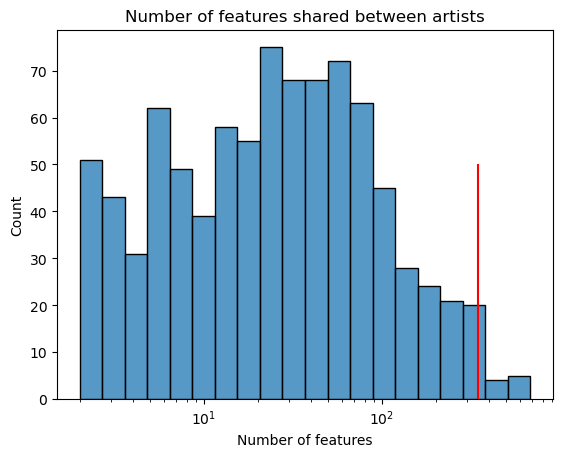

In [83]:
li = [v for k,v in GGG.degree(weight='weight') if v > 1]
li2 = np.array(li)
sns.histplot(li2, bins=20, log_scale=True)
#plt.hist(li2, bins=20)
plt.title('Number of features shared between artists')
plt.xlabel('Number of features')
plt.ylabel('Count')
#plt.vlines(348, ymin=0, ymax=50, color='red')
plt.show()

In [100]:
# Who has the most features shared with other artists?

li = [(k,v) for k,v in GGG.degree(weight='weight') if v > 1]
pd.DataFrame(li, columns=['artist name', 'number of features']).sort_values(by='number of features', ascending=False).head(10)

,artist name,number of features
14,Young Thug,683
8,Future,619
32,Lil Wayne,583
98,Gucci Mane,504
134,French Montana,459
88,Rick Ross,395
72,Juicy J,376
34,Lil Durk,375
143,DJ Drama,367
142,Metro Boomin,365


Begin making of network / graph

In [ ]:
import netwulf as nw
network, config = nw.visualize( GGG.copy() , plot_in_cell_below=True)

## Text analysis - Top songs 

In [10]:
response2 = get_songs_by_artist(token, id1)

In [13]:
for song in response2['tracks']: #[0]#['artists']
    print(song['name'])

As It Was
Watermelon Sugar
Late Night Talking
Adore You
Sign of the Times
Falling
Matilda
Music For a Sushi Restaurant
Satellite
Golden


In [33]:
# read pickle file
with open('dict_features01.pickle', 'rb') as handle:
    dict_features1 = pickle.load(handle)

with open('dict_features02.pickle', 'rb') as handle:
    dict_features2 = pickle.load(handle)

with open('dict_features03.pickle', 'rb') as handle:
    dict_features3 = pickle.load(handle)

In [36]:
dict_features_all = {**dict_features1, **dict_features2, **dict_features3}
len(dict_features_all)

1250

In [37]:
with open('dict_featuresALL.pickle', 'wb') as handle:
    pickle.dump(dict_features_all, handle)

In [26]:
np.where(unique_artists == 'Nat King Cole Trio')

(array([1113]),)

In [28]:
unique_artists[1114:]

array(['Johnny Mathis', 'grandson', 'The Strokes', 'Bee Gees',
       'New Community Church', "Destiny's Child", 'Jameson Rodgers',
       'Passion Pit', 'HAIM', 'Dj Ozuna', 'Thirty Seconds To Mars',
       'Kim Cesarion', 'ODESZA', 'Cobra Starship', 'Michael Ray',
       'Wizkid', 'Soundgarden', 'Coleman Hell', 'iSHi',
       'Theophilus London', 'Chad Focus', 'David Bowie', 'Roy Woods',
       'Jaymes Reunion', 'Foster The People', 'Jennifer Lopez',
       'Alicia Keys', 'SNBRN', 'Shaun Reynolds', 'Radiohead', 'JoJo',
       'TWENTY88', 'Kalin and Myles', 'AronChupa', 'Niykee Heaton',
       'Chedda Da Connect', 'The Low Down', 'Miike Snow', 'New Politics',
       'Florence + The Machine', 'Beck', 'AFROJACK', 'Ludacris', 'Priory',
       'Fences', 'Seth MacFarlane', 'Nico Segal', 'Ace Hood',
       'Mary Lambert', 'Phoebe Ryan', 'LÃ\x89ON', 'Bankroll Fresh',
       'Alabama Shakes', 'Ryan Adams', 'Snoop Dogg',
       'Edward Sharpe & The Magnetic Zeros', 'The-Dream', 'Moxie Raia',
  

# The actual delievery

## Motovation


What is your dataset?

Why did you choose this/these particular dataset(s)?

What was your goal for the end user’s experience?

## Basic stats. Let’s understand the dataset better


Write about your choices in data cleaning and preprocessing

    - Is the list actually top artists
    - Some songs are included multiple times (because remix' etc. )
    - Determination of genre
    

Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)

## Tools, theory and analysis. Describe the process of theory to insight


Talk about how you’ve worked with text, including regular expressions, unicode, etc.

Describe which network science tools and data analysis strategies you’ve used, how those network science measures work, and why the tools you’ve chosen are right for the problem you’re solving.

How did you use the tools to understand your dataset?

## Discussion. Think critically about your creation



What went well?

What is still missing? What could be improved? Why?